### Data Pre-processing. No need to run. The processed .shp and .geojson are already in LEM_ROI folder

In [4]:
#import geopandas as gpd
#LEM_raw = gpd.read_file('./LEM_raw/LEM_dataset.shp')
#LEM = gpd.read_file('./LEM_ROI/LEM_ROI.shp')
#LEM contains some multipolygons, we need to exclude them
#LEM = LEM[LEM.geometry.geom_type == 'Polygon']
#LEM = LEM.reset_index()

In [5]:
# Save to GeoJSON
#LEM.to_file('./LEM_ROI/LEM_ROI.geojson', driver='GeoJSON')
#LEM.to_file('./LEM_ROI/LEM_ROI.shp', driver='ESRI Shapefile')

### The polygons in the southern area were excluded to reduce the file size of the images. As a result, the number of polygons was reduced from 1854 to 1502.

In [6]:
import geopandas as gpd
LEM_raw = gpd.read_file('./LEM_raw/LEM_dataset.shp')
LEM = gpd.read_file('./LEM_ROI/LEM_ROI.shp')

In [7]:
print('LEM Shape:',LEM.shape)
LEM['Type'].value_counts()

LEM Shape: (1502, 17)


Train    1267
Test      235
Name: Type, dtype: int64

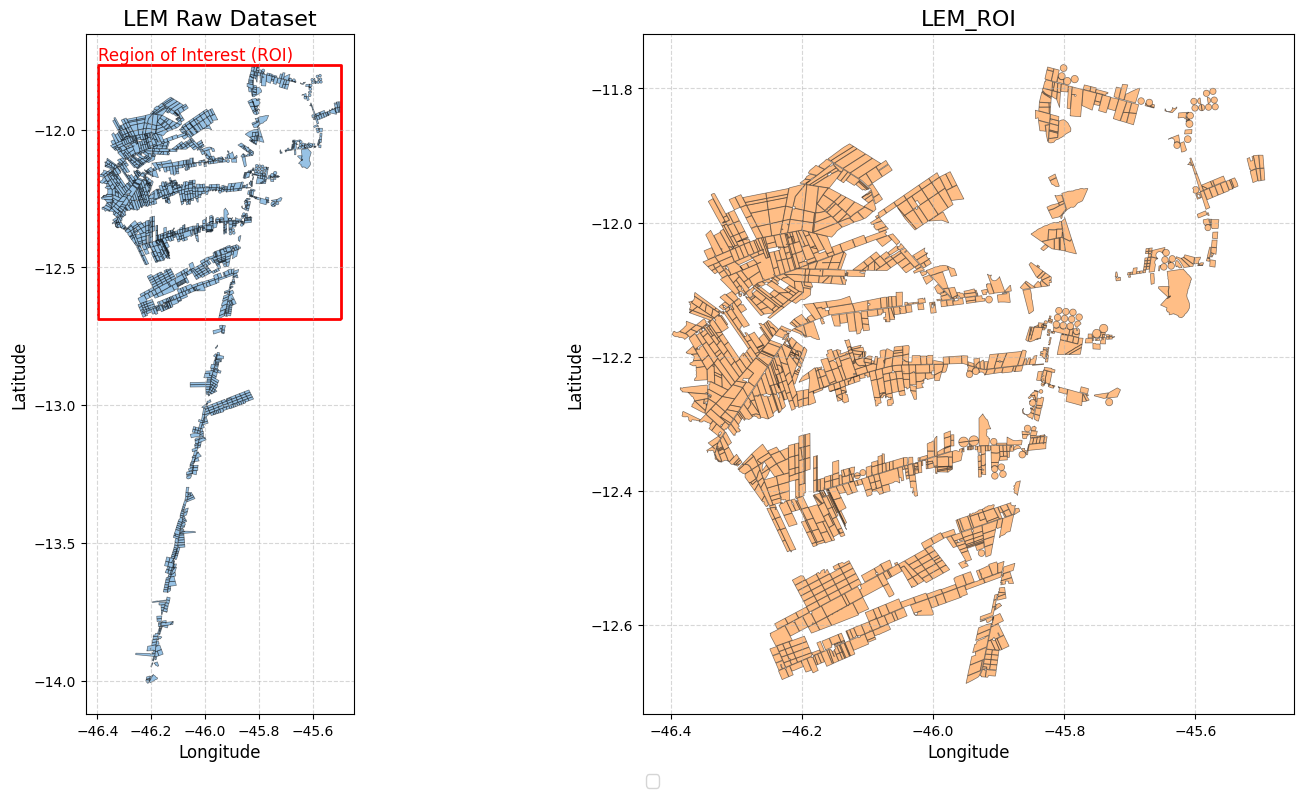

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# Calculate bounds of the zoomed-in area
bounds = LEM.total_bounds  # [minx, miny, maxx, maxy]
red_box = box(bounds[0], bounds[1], bounds[2], bounds[3])  # Red box geometry

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=100)  # Larger, higher-resolution figure

# Plot the first dataset (LEM_raw) with a red box
LEM_raw.plot(
    ax=axes[0],
    color='#3186cc',  # Blue fill
    edgecolor='black',  # Black border
    linewidth=0.5,
    alpha=0.5
)
gpd.GeoSeries([red_box], crs=LEM_raw.crs).plot(
    ax=axes[0],
    edgecolor='red',  # Red border
    facecolor='none',  # Transparent fill
    linewidth=2
)
axes[0].set_title("LEM Raw Dataset", fontsize=16, pad=6)
axes[0].set_xlabel("Longitude", fontsize=12)
axes[0].set_ylabel("Latitude", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Add a text label to the red box
axes[0].text(bounds[0], bounds[3], 'Region of Interest (ROI)', color='red', fontsize=12, ha='left', va='bottom')

# Plot the second dataset (LEM)
LEM.plot(
    ax=axes[1],
    color='#ff7f0e',  # Orange fill
    edgecolor='black',  # Black border
    linewidth=0.5,
    alpha=0.5
)
axes[1].set_title("LEM_ROI", fontsize=16, pad=6)
axes[1].set_xlabel("Longitude", fontsize=12)
axes[1].set_ylabel("Latitude", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Add legend
fig.legend(['LEM_raw', 'LEM'], loc='lower center', fontsize=12, ncol=2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Space for legend

# Show the plot
plt.show()

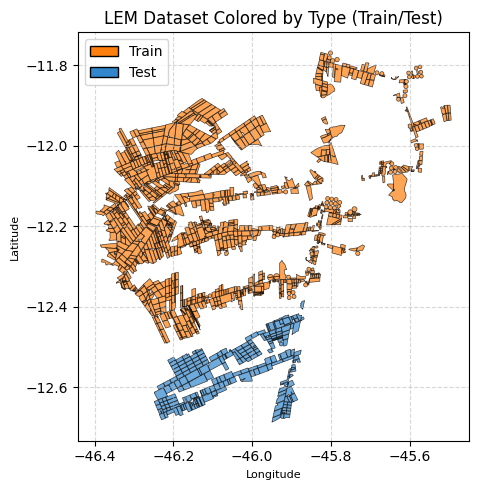

In [9]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

# Plot the LEM dataset, coloring by the 'Type' column
LEM.plot(
    ax=ax,
    column='Type',  # Use the 'Type' column for coloring
    cmap=ListedColormap(['#3186cc', '#ff7f0e']),  # Blue for Train, Orange for Test
    edgecolor='black',  # Black border
    linewidth=0.5,
    alpha=0.7
)

# Add title and labels
ax.set_title("LEM Dataset Colored by Type (Train/Test)", fontsize=12, pad=6)
ax.set_xlabel("Longitude", fontsize=8)
ax.set_ylabel("Latitude", fontsize=8)
ax.grid(True, linestyle='--', alpha=0.5)

# Create a custom legend
legend_labels = ['Train', 'Test']
legend_elements = [
    Patch(facecolor='#ff7f0e', edgecolor='black', label='Train'),
    Patch(facecolor='#3186cc', edgecolor='black', label='Test')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

Image shape: (5134, 5032, 16)


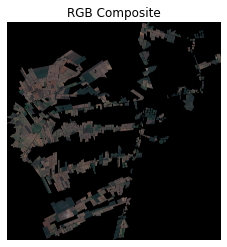

In [10]:
import os 
import numpy as np
from skimage.io import imread

# Load the image
image = imread("EarthEngine-clipped-exports/Sentinel2_Clipped_2020-05-04.tif")

# Check the shape of the image
print("Image shape:", image.shape)

# Select RGB bands (adjust indices if necessary)
red = image[:, :, 3]    # Band 4
green = image[:, :, 2]  # Band 3
blue = image[:, :, 1]   # Band 2
nir = image[:,:,7]      # Band 8
# Normalize values for visualization
red_filled = np.nan_to_num(red, nan=0)
green_filled = np.nan_to_num(green, nan=0)
blue_filled = np.nan_to_num(blue, nan=0)
nir_filled = np.nan_to_num(nir, nan=0)

red_filled = red_filled / np.max(red_filled)
green_filled = green_filled / np.max(green_filled)
blue_filled = blue_filled / np.max(blue_filled)

# Stack RGB
rgb_image_normalized = np.stack((red_filled, green_filled, blue_filled), axis=-1)
# Visualize the RGB composite
plt.imshow(rgb_image_normalized)
plt.title("RGB Composite")
plt.axis('off')
plt.show()

In [11]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd

# Open the raster file
with rasterio.open('EarthEngine-clipped-exports/Sentinel2_Clipped_2020-05-04.tif') as src:  # Replace with your raster path
    # Get the CRS of the raster
    image_crs = src.crs
    
    # Reproject polygons to match the image CRS
    if LEM.crs != image_crs:
        LEM = LEM.to_crs(image_crs)
        print("Polygons reprojected to match image CRS.")
    
    # Select RGB + NIR bands (assuming Sentinel-2 band indices: 2=Blue, 3=Green, 4=Red, 8=NIR)
    desired_band_indices = [2, 3, 4, 8]  # These are 1-based indices for Sentinel-2

    # Initialize a list to store features
    all_features = []
    num_bins = 10  # Number of bins for histogram features

    # Loop through each polygon
    for idx, row in LEM.iterrows():
        geom = [row['geometry']]  # Extract the geometry as a list
        
        # Mask the image by the polygon
        try:
            out_image, out_transform = rasterio.mask.mask(src, geom, crop=True, filled=True, nodata=np.nan)
            # Select only desired bands (convert 1-based indices to 0-based)
            out_image = out_image[desired_band_indices, :, :]
            out_image = np.moveaxis(out_image, 0, -1)  # Reformat to (height, width, bands)
        except ValueError:
            # If the polygon doesn't intersect the image, skip it
            all_features.append([np.nan] * (len(desired_band_indices) * (2 + num_bins)))  # Placeholder
            continue

        # Remove NaN values
        valid_pixels = ~np.isnan(out_image).any(axis=-1)
        pixel_values = out_image[valid_pixels]

        if pixel_values.size > 0:  # Skip empty polygons
            # Compute features
            avg_features = np.mean(pixel_values, axis=0)
            std_features = np.std(pixel_values, axis=0)
            
            # Compute histogram features for each band
            hist_features = []
            for band in range(pixel_values.shape[1]):
                hist, _ = np.histogram(pixel_values[:, band], bins=num_bins)
                hist_features.extend(hist)
            
            # Combine features
            combined_features = np.concatenate([avg_features, std_features, hist_features])
            all_features.append(combined_features)
        else:
            # Append NaN features for empty polygons
            all_features.append([np.nan] * (len(desired_band_indices) * (2 + num_bins)))

# Convert features to DataFrame
num_features = len(desired_band_indices) * (2 + num_bins)  # Total features = bands * (avg + std + histogram bins)
features_df = pd.DataFrame(all_features, columns=[f'feature_{i}' for i in range(num_features)])


In [12]:
features_df['Type'] = LEM['Type']  # Add the Type column from LEM

### Task 1: Only interested in the lands which crop's type did not change throughout the year

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  # For saving and loading the model

In [14]:
# List of columns representing monthly crop types
monthly_columns = [
    'Oct_2019', 'Nov_2019', 'Dec_2019', 'Jan_2020',
    'Feb_2020', 'Mar_2020', 'Apr_2020', 'May_2020',
    'Jun_2020', 'Jul_2020', 'Aug_2020', 'Sep_2020'
]

# Check if all crop types in a polygon are the same across the 12 months
LEM['consistent'] = LEM[monthly_columns].nunique(axis=1) == 1

# Filter polygons with consistent crop types
LEM_consistent = LEM[LEM['consistent']]

In [15]:
features_consistent = features_df.loc[LEM_consistent.index]

In [16]:
train_consistent = features_consistent[features_consistent['Type'] == 'Train']
test_consistent = features_consistent[features_consistent['Type'] == 'Test']

# Extract features
X_train = train_consistent.filter(regex='^feature_').values
X_test = test_consistent.filter(regex='^feature_').values

# Extract labels (assuming the actual labels are in a column named 'Label')
y_train = LEM_consistent.loc[LEM_consistent['Type'] == 'Train', 'May_2020'].values
y_test = LEM_consistent.loc[LEM_consistent['Type'] == 'Test', 'May_2020'].values

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model on the training data
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

Accuracy: 0.27
                 precision    recall  f1-score   support

        Cerrado       0.00      0.00      0.00        10
Conversion area       0.00      0.00      0.00         0
        Pasture       0.44      0.80      0.57         5

       accuracy                           0.27        15
      macro avg       0.15      0.27      0.19        15
   weighted avg       0.15      0.27      0.19        15



/Users/ching-chichou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ching-chichou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ching-chichou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Us

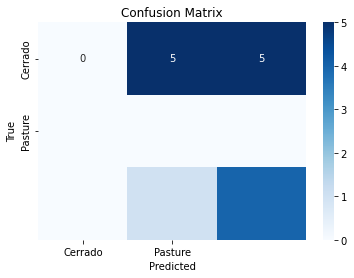

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on the testing set
y_pred = rf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import numpy as np
from collections import Counter

print("True label distribution:", Counter(y_test))
print("Predicted label distribution:", Counter(y_pred))

True label distribution: Counter({'Uncultivated soil': 126, 'Cotton': 54, 'Corn': 12, 'Millet': 12, 'Cerrado': 10, 'Sorghum': 6, 'Pasture': 5, 'Brachiaria': 4, 'Soybean': 3, 'Not identified': 2, 'Crotalaria': 1})
Predicted label distribution: Counter({'Uncultivated soil': 233, 'Corn': 1, 'Millet': 1})


### Additional Test: Use a single month(May) to train/test

In [19]:
train_df = features_df[features_df['Type'] == 'Train']
test_df = features_df[features_df['Type'] == 'Test']
# Extract features
X_train = train_df.filter(regex='^feature_').values
X_test = test_df.filter(regex='^feature_').values

# Extract labels (assuming the actual labels are in a column named 'Label')
y_train = LEM.loc[LEM['Type'] == 'Train', 'May_2020'].values
y_test = LEM.loc[LEM['Type'] == 'Test', 'May_2020'].values

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model on the training data
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

Accuracy: 0.53
                   precision    recall  f1-score   support

       Brachiaria       0.00      0.00      0.00         4
          Cerrado       0.00      0.00      0.00        10
             Corn       0.00      0.00      0.00        12
           Cotton       0.00      0.00      0.00        54
       Crotalaria       0.00      0.00      0.00         1
           Millet       0.00      0.00      0.00        12
   Not identified       0.00      0.00      0.00         2
          Pasture       0.00      0.00      0.00         5
          Sorghum       0.00      0.00      0.00         6
          Soybean       0.00      0.00      0.00         3
Uncultivated soil       0.53      0.98      0.69       126

         accuracy                           0.53       235
        macro avg       0.05      0.09      0.06       235
     weighted avg       0.29      0.53      0.37       235



/Users/ching-chichou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ching-chichou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ching-chichou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

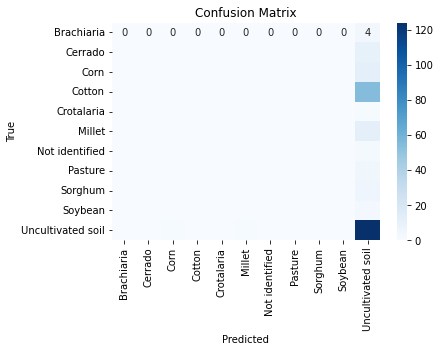

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on the testing set
y_pred = rf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
LEM[LEM['Type'] == 'Test']['May_2020'].value_counts()

Uncultivated soil    126
Cotton                54
Corn                  12
Millet                12
Cerrado               10
Sorghum                6
Pasture                5
Brachiaria             4
Soybean                3
Not identified         2
Crotalaria             1
Name: May_2020, dtype: int64